## Filter Decomposition - Multi Output Regression Approach

### Importing Libraries

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import gradio as gr
from skimage.metrics import structural_similarity as ssim


import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from fimage import FImage
from fimage.filters import Contrast, Brightness, Saturation, Hue, Exposure, Grayscale, Sharpen, Sepia,  Vibrance, Posterize, Noise

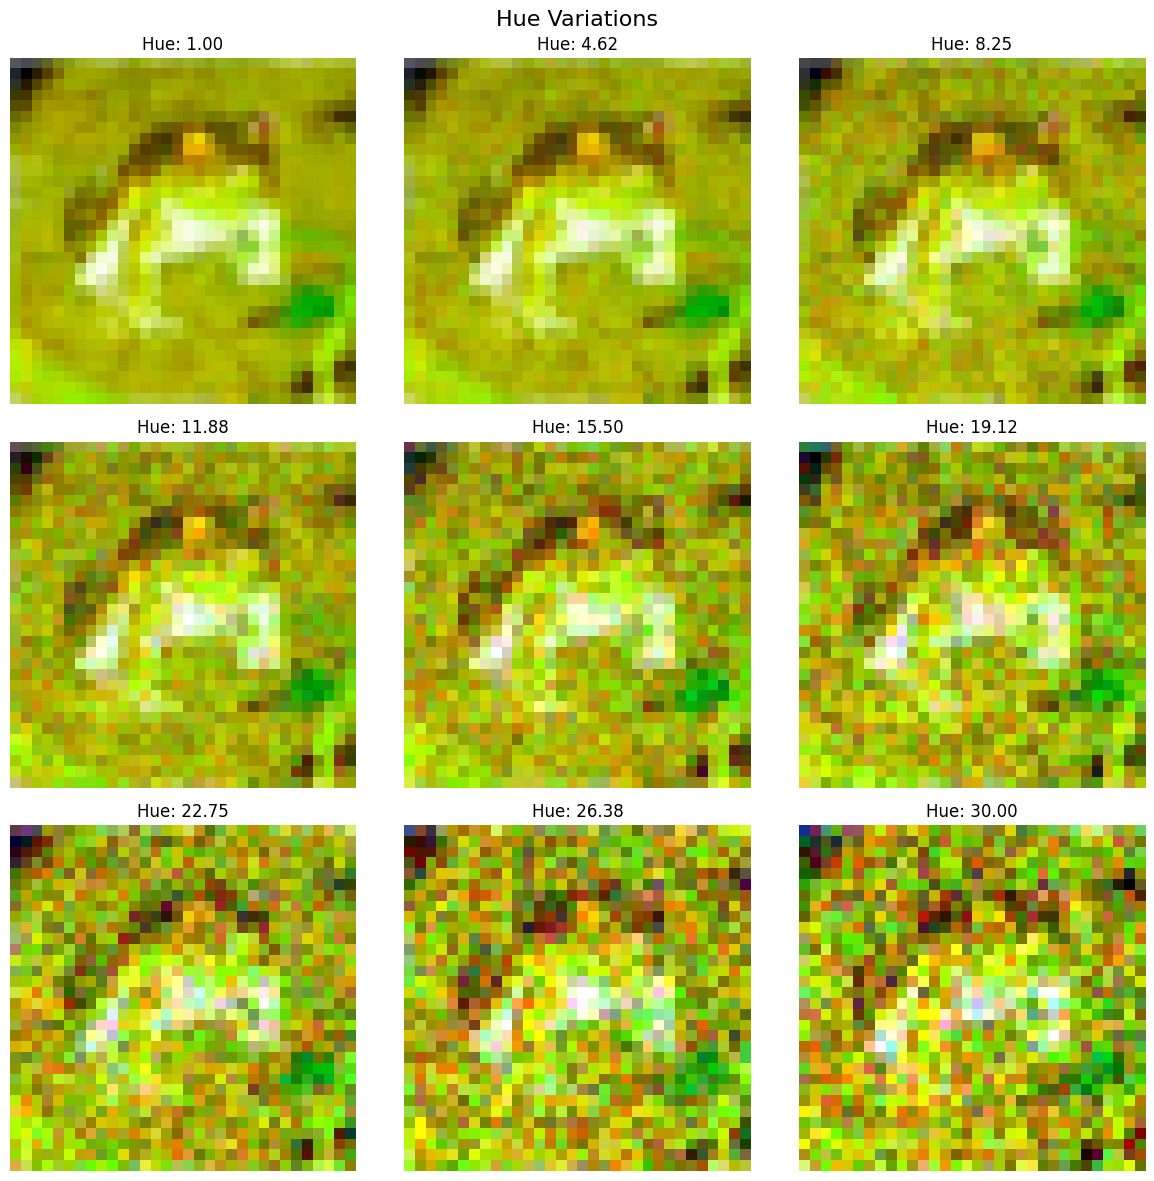

In [3]:
def plot_hue_variations(image_path, levels=9):
    # Create figure with 3x3 subplots
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle('Hue Variations', fontsize=16)
    
    # Load original image using FImage
    
    # Generate hue values from -1.0 to 1.0
    hue_values = np.linspace(1.0, 30.0, levels)
    
    # Plot each variation
    for idx, hue in enumerate(hue_values):
        row = idx // 3
        col = idx % 3
        
        # Create a copy and apply hue filter

        img = FImage(image_path)
        img.apply(Noise(hue))
        
        # Display the image
        axes[row, col].imshow(img.image)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Hue: {hue:.2f}')
    
    plt.tight_layout()
    plt.show()

# Example usage with your image path
img_path = "../results/images/cifar_0_v1.png"
plot_hue_variations(img_path)

### Loading Dataset

In [4]:
IMAGE_DIR = '../results/images'
METADATA_PATH = '../results/metadata.csv'
BATCH_SIZE = 16
IMG_SIZE = (260, 260)
FILTERS = ['Contrast', 'Brightness', 'Saturation', 'Hue', 'Exposure', 'Vibrance', 'Sepia', 'Sharpen', 'Noise']

In [6]:
df = pd.read_csv(METADATA_PATH)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [8]:
class FilterDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None, normalize_intensities=True):
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform
        self.filter_cols = self.df.columns.to_list()[1:]  
        self.normalize_intensities = normalize_intensities
        self.max_values = torch.tensor(list(map(lambda c: self.df[c].max(), self.filter_cols)))
        # TODO: if some filter is in negatives this breaks
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(os.path.join(self.image_dir, row['Id'])).convert("RGB")
        
        intensities = torch.tensor(row[self.filter_cols].values.astype(np.float32))
        
        if self.normalize_intensities:
            intensities = intensities / self.max_values
        
        if self.transform:
            image = self.transform(image)
        
        return image, intensities

In [9]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FilterDataset(METADATA_PATH, IMAGE_DIR, transform=transform, normalize_intensities=True)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)


In [10]:
_, l = next(iter(train_loader))

### Model Architecture

In [11]:
class MultiOutputEfficientNet(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(MultiOutputEfficientNet, self).__init__()
        self.base_model = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)

        in_features = self.base_model.classifier[1].in_features
        
        self.base_model.classifier = nn.Identity()

        self.filter_heads = nn.ModuleDict()
        for i in range(len(FILTERS)):
            self.filter_heads[FILTERS[i]] = nn.Sequential(
                nn.Linear(in_features, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate * 0.5),
                
                nn.Linear(128, 1),
                nn.Sigmoid()
            )
        
    def forward(self, x):
        features = self.base_model(x)
        
        outputs = []
        for head in self.filter_heads.values():
            outputs.append(head(features))
        
        return torch.cat(outputs, dim=1)
      

model = MultiOutputEfficientNet()
model = model.to(device)


In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training 

In [13]:
def train_step(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        y_pred = model(inputs)
        loss = criterion(y_pred, labels)
        train_loss += loss
        loss.backward()
        
        optimizer.step()

    return float(train_loss)

In [14]:
def val_step(model, dataloader, criterion):
    model.eval()
    mses = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            y_pred = model(inputs)
            mse = criterion(y_pred, labels)
            mses += mse

    return float(mses)

In [15]:
loss = train_step(model, train_loader, criterion, optimizer)
loss

5.02274751663208

In [16]:
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_targets = [], [] 

    with torch.inference_mode():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            y_pred = model(inputs)

            all_preds.append(y_pred.cpu())
            all_targets.append(labels.cpu())


    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # 1) MSE per filter (vector of length 5) and overall
    mse_per_filter = mean_squared_error(all_targets, all_preds, multioutput='raw_values')
    mse_overall    = mean_squared_error(all_targets, all_preds, multioutput='uniform_average')

    # 2) RMSE (take sqrt of each MSE)
    rmse_per_filter = mse_per_filter ** 0.5
    rmse_overall    = mse_overall ** 0.5

    # 3) MAE per filter and overall
    mae_per_filter = mean_absolute_error(all_targets, all_preds, multioutput='raw_values')
    mae_overall    = mean_absolute_error(all_targets, all_preds, multioutput='uniform_average')

    # 4) R^2 per filter and overall (can also do multioutput='variance_weighted')
    r2_per_filter = []

    for i in range(all_targets.shape[1]):
        r2_per_filter.append(r2_score(all_targets[:, i], all_preds[:, i]))

    r2_overall = r2_score(all_targets, all_preds, multioutput='uniform_average')

    metrics = {
        "mse_per_filter":    mse_per_filter.tolist(),
        "mse_overall":       float(mse_overall),
        "rmse_per_filter":   rmse_per_filter.tolist(),
        "rmse_overall":      float(rmse_overall),
        "mae_per_filter":    mae_per_filter.tolist(),
        "mae_overall":       float(mae_overall),
        "r2_per_filter":     r2_per_filter,
        "r2_overall":        float(r2_overall),
    }
    return metrics


In [17]:
def train(model, dataloaders, criterion, optimizer, epochs=10):
    res = {"train_mse": [], "val_mse": []}

    bar = tqdm(range(epochs), desc="Training", unit="epoch")

    for epoch in bar:
        # if epoch >= 5:
        #     for params in model.base_model.parameters():
        #         params.requires_grad = True 

        train_mse = train_step(model, dataloaders["train"], criterion, optimizer)
        val_mse = val_step(model, dataloaders["val"], criterion)

        bar.set_description(f"Epoch {epoch+1}/{epochs}")
        bar.set_postfix({
            "train_mse": f"{train_mse:.4f}",
            "val_mse": f"{val_mse:.4f}"
        })

        res["train_mse"].append(train_mse)
        res["val_mse"].append(val_mse)

    return res

In [18]:
def plot_training_history(res):
    epochs = range(1, len(res["train_mse"]) + 1)
    
    plt.figure()
    plt.plot(epochs, res["train_mse"], label="Train MSE", marker='o')
    plt.plot(epochs, res["val_mse"], label="Val MSE", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Training vs Validation MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
dataloaders = {
    "train": train_loader,
    "val": test_loader
}

In [20]:
res = train(model, dataloaders, criterion, optimizer, epochs=10)

Epoch 10/10: 100%|██████████| 10/10 [20:30<00:00, 123.05s/epoch, train_mse=1.2751, val_mse=1.0442]


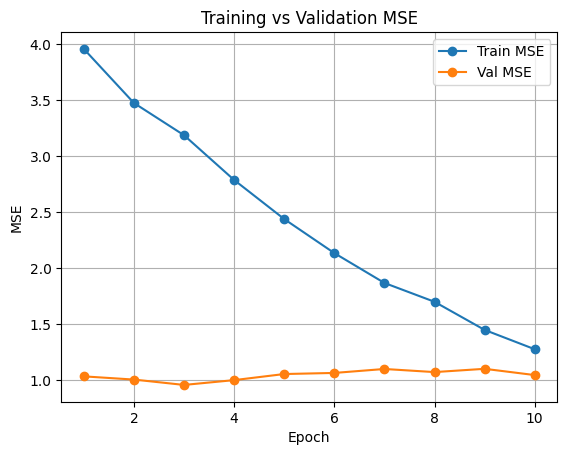

In [21]:
plot_training_history(res)

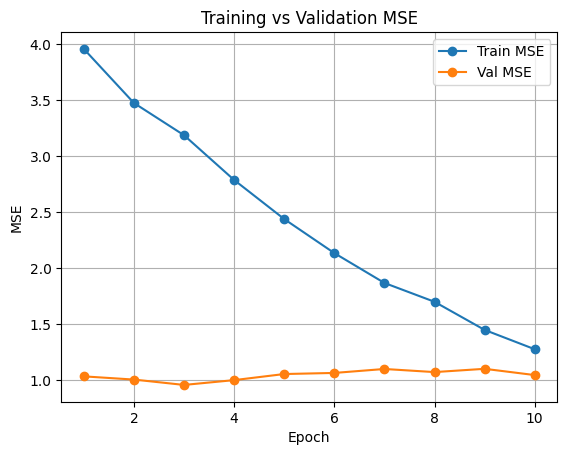

In [22]:

plot_training_history(res)

In [23]:
metrics = evaluate(model, test_loader)
metrics

{'mse_per_filter': [0.04859133064746857,
  0.06153373792767525,
  0.12333828210830688,
  0.11153434962034225,
  0.14030608534812927,
  0.13478854298591614,
  0.06546823680400848,
  0.03272427245974541,
  0.01034396793693304],
 'mse_overall': 0.08095875382423401,
 'rmse_per_filter': [0.22043441236019135,
  0.248059943318367,
  0.3511955142021179,
  0.3339675962924957,
  0.37457454204559326,
  0.36713558435440063,
  0.2558676302433014,
  0.180898517370224,
  0.10170529782772064],
 'rmse_overall': 0.2845325180436043,
 'mae_per_filter': [0.14347201585769653,
  0.1667109727859497,
  0.25800055265426636,
  0.22847099602222443,
  0.30300086736679077,
  0.30117252469062805,
  0.18489833176136017,
  0.10755226016044617,
  0.058066997677087784],
 'mae_overall': 0.19459395110607147,
 'r2_per_filter': [0.5773980617523193,
  0.5009175539016724,
  -0.036249756813049316,
  -0.08683371543884277,
  -0.11216330528259277,
  -0.20224952697753906,
  0.4567508101463318,
  0.7129875421524048,
  0.90549039840

In [24]:
uh = pd.read_csv(METADATA_PATH)
print(uh.head())

                 Id  Contrast  Brightness  Saturation  Hue  Exposure  \
0    cifar_0_v1.png        57           0          17   27         0   
1    cifar_1_v1.png        61          11           0   90        24   
2   cifar_10_v1.png        15           0          36   86         0   
3  cifar_100_v1.png         0           0           0   18         0   
4  cifar_101_v1.png        55           0           0   56        21   

   Vibrance  Sepia  Sharpen  Noise  
0         0     43        0     13  
1         0     57        0      7  
2         0      0       39      6  
3        77     56        0     18  
4         0     38       60      0  


In [25]:
filter_cols = uh.columns.to_list()[1:]
filter_cols

['Contrast',
 'Brightness',
 'Saturation',
 'Hue',
 'Exposure',
 'Vibrance',
 'Sepia',
 'Sharpen',
 'Noise']

In [26]:
maxes = list(map(lambda c: uh[c].max(), filter_cols))
maxes

[np.int64(75),
 np.int64(30),
 np.int64(100),
 np.int64(100),
 np.int64(30),
 np.int64(100),
 np.int64(100),
 np.int64(75),
 np.int64(30)]

In [30]:
def visualize_predictions(model, dataloader, idx):
    model.eval()

    with torch.inference_mode():
        inputs, targets = next(iter(dataloader))
        inputs, targets = inputs.to(device), targets.to(device)
        y_pred = model(inputs)

        first_prediction = y_pred[idx].cpu().numpy()
        first_target = targets[idx].cpu().numpy()

        for (pred, target, mx, f) in zip(first_prediction, first_target, maxes, filter_cols):
            scaled_pred = pred * mx
            scaled_target = target * mx

            print(f"Filter: {f}")
            print(f"Predicted filter: {scaled_pred:.4f}")
            print(f"Actual filter: {scaled_target:.4f}")
            print("----------------------")

        # TODO then apply the predicted filters to see how it worked

In [31]:
def infer_image(model, img_path, max_value=85.0):
    model.eval()

    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.inference_mode():
        pred = model(input_tensor).squeeze(0).cpu().numpy()

    scaled_pred = pred * max_value

    print(f"Predicted filters for {os.path.basename(img_path)}:")
    for name, value in zip(FILTERS, scaled_pred):
        print(f"{name}: {value:.2f}")


In [32]:
visualize_predictions(model, test_loader,12)

Filter: Contrast
Predicted filter: 6.4499
Actual filter: 39.0000
----------------------
Filter: Brightness
Predicted filter: 0.2130
Actual filter: 0.0000
----------------------
Filter: Saturation
Predicted filter: 34.7804
Actual filter: 37.0000
----------------------
Filter: Hue
Predicted filter: 3.0377
Actual filter: 0.0000
----------------------
Filter: Exposure
Predicted filter: 1.1051
Actual filter: 0.0000
----------------------
Filter: Vibrance
Predicted filter: 27.0864
Actual filter: 71.0000
----------------------
Filter: Sepia
Predicted filter: 6.0473
Actual filter: 21.0000
----------------------
Filter: Sharpen
Predicted filter: 1.1677
Actual filter: 0.0000
----------------------
Filter: Noise
Predicted filter: 11.0277
Actual filter: 7.0000
----------------------


In [101]:
FILTER_MAP = {
    'Contrast': (Contrast, (10, 75)),
    'Brightness': (Brightness, (5, 30)),
    'Saturation': (Saturation, (10, 100)),
    'Hue': (Hue, (0, 100)),
    'Exposure': (Exposure, (10, 30)),
    'Vibrance': (Vibrance, (20, 100)),
    'Sepia': (Sepia, (15, 100)),
    'Sharpen': (Sharpen, (10, 75)),
    'Noise': (Noise, (1, 30)),
}

In [102]:
def apply_random_filtering(img_path: Path, output_dir: Path):
    os.makedirs(output_dir, exist_ok=True)

    filters_to_apply = []
    for filter_name, (filter_class, (min_val, max_val)) in FILTER_MAP.items():
        if random.random() < 0.5:
            filters_to_apply.append(filter_class(random.randint(min_val, max_val)))

    image = FImage(img_path)
    for filter_obj in filters_to_apply:
        image.apply(filter_obj)

    if image.original_image.mode != "RGB":
        image = image.original_image.convert("RGB")
    
    image.save(output_dir / img_path.name)

In [103]:
def apply_model_filtering(model, img_path: Path, output_dir: Path):
    os.makedirs(output_dir, exist_ok=True)

    model.eval()

    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.inference_mode():
        pred = model(input_tensor).squeeze(0).cpu().numpy()

    filters_to_apply = []
    for (filter_name, (filter_class, (min_val, max_val))), pred_value in zip(FILTER_MAP.items(), pred):
        scaled_value = pred_value * (max_val - min_val) + min_val
        filters_to_apply.append(filter_class(scaled_value))

    image = FImage(img_path)
    for filter_obj in filters_to_apply:
        image.apply(filter_obj)
    
    image.save(output_dir / img_path.name)


In [104]:
import gradio as gr
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import tempfile
import uuid

def load_image(path: Path):
    return np.array(Image.open(path).convert("RGB")) / 255.0

def evaluate_with_ssim(original, filtered, predicted_filtered):
    ssim_value = ssim(filtered, predicted_filtered, channel_axis=-1, data_range=1.0)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    titles = ['Original', 'Filtered', f'Predicted Filtered\nSSIM: {ssim_value:.4f}']
    images = [original, filtered, predicted_filtered]
    
    for i in range(3):
        axs[i].imshow(images[i])
        axs[i].set_title(titles[i])
        axs[i].axis('off')

    fig.tight_layout()
    return fig, f"SSIM between filtered and predicted_filtered: {ssim_value:.4f}"

def pipeline(img_path):
    with tempfile.TemporaryDirectory() as temp_dir:
        img_path = Path(img_path)
        temp_dir = Path(temp_dir)

        filtered_path = temp_dir / "filtered"
        predicted_path = temp_dir / "predicted_filtered"

        # Apply filtering and model
        apply_random_filtering(img_path, filtered_path)
        apply_model_filtering(model, img_path, predicted_path)

        # Load the output images
        original = load_image(img_path)
        filtered = load_image(filtered_path / img_path.name)
        predicted_filtered = load_image(predicted_path / img_path.name)

        return evaluate_with_ssim(original, filtered, predicted_filtered)

# Launch Gradio app
gr.Interface(
    fn=pipeline,
    inputs=gr.Image(type="filepath", label="Upload Image"),
    outputs=[
        gr.Plot(label="Image Comparison"),
        gr.Textbox(label="SSIM Score")
    ],
    title="Filter Decomposer Evaluation with Real Model"
).launch()

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


In [106]:
torch.save(model.state_dict(), '../results/multi_output_efficientnet.pth')